In [198]:
import keras
print(keras.__version__)

3.6.0


In [199]:
import numpy as np
import matplotlib.pyplot as plt


In [200]:
def conical_surface(eccentricity, num_points=100):
    if eccentricity < 0:
        raise ValueError("Eccentricity must be non-negative.")
    
    t = np.linspace(-np.pi, np.pi, num_points)
    a =1.0
    if eccentricity < 1:  # Ellipse
        b = a * np.sqrt(1 - eccentricity**2)
        x = a * np.cos(t)
        y = b * np.sin(t)
    elif eccentricity == 1:  # Parabola
        x = 2 * a * t
        y = t**2 
    else:  # Hyperbola
        b = a * np.sqrt(eccentricity**2 - 1)
        y = a * np.cosh(t)
        x = b * np.sinh(t)
    
    return x, y

In [201]:
e=1.1
x,y = conical_surface(e,1000)

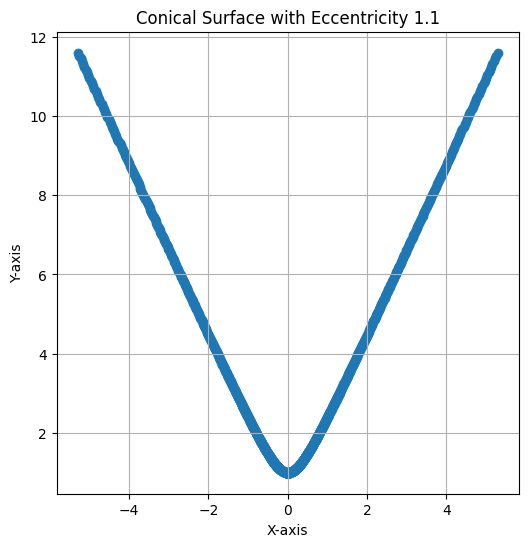

In [202]:
plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Conical Surface with Eccentricity {e}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [203]:
def generate_elipses(e,a=1,num_points=100):
    t = np.linspace(-np.pi, np.pi, num_points)
    
    b = a * np.sqrt(1 - e**2)
    x = a * np.cos(t)
    y = b * np.sin(t)
    return x,y

In [204]:
def apply_rotation_translation(x,y,xt=0,yt=0,angle_rad=0):
    xf = xt + x * np.cos(angle_rad) - y * np.sin(angle_rad)
    yf = yt + x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return xf,yf

[]

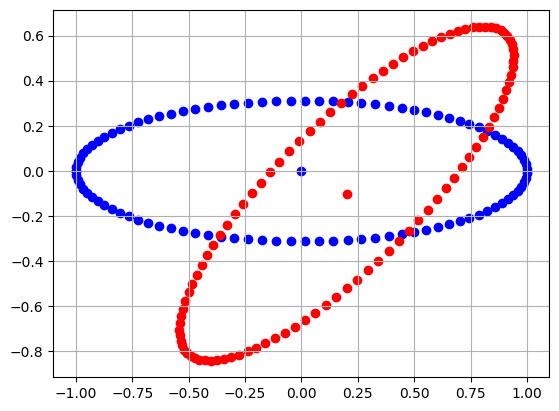

In [205]:
testex,testey=generate_elipses(0.95,1,100)
xt=0.2
yt=-0.1
tx,ty=apply_rotation_translation(testex,testey,xt,yt,np.pi/4)
plt.scatter(testex,testey,color="blue")
plt.scatter(0,0,color="blue")
plt.scatter(tx,ty,color="red")
plt.scatter(xt,yt,color="red")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.plot()

In [206]:
import random
x_values = []
y_values = []
samples=50000
num_points=100
e_values=np.random.rand(samples)
a_values=100*np.random.rand(int(samples))

angle_values=2*np.pi*np.random.rand(samples)
xt_values=100*np.random.rand(samples)
yt_values=100*np.random.rand(samples)

for e,a,angle,xt,yt in zip(e_values,a_values,angle_values,xt_values,yt_values):
    x,y=generate_elipses(e,a,num_points)
    xf,yf=apply_rotation_translation(x,y,xt,yt,angle)
    x_values.append(xf)  # Append x values to list
    y_values.append(yf)  # Append y values to list



In [207]:
#lets add noise
x_noise=[]
y_noise=[]

noise_level=0.5

for a,x in zip(a_values,x_values):
    noisex= np.random.normal(loc=0,scale=a/15,size=num_points)
    x_noise.append(noisex+x)
for a,y in zip(a_values,y_values):
    noisey= np.random.normal(loc=0,scale=a/15,size=num_points)
    y_noise.append(noisey+y)

#x_noise=x_values+a_values*noisex
#y_noise=y_values*a_values*noisey


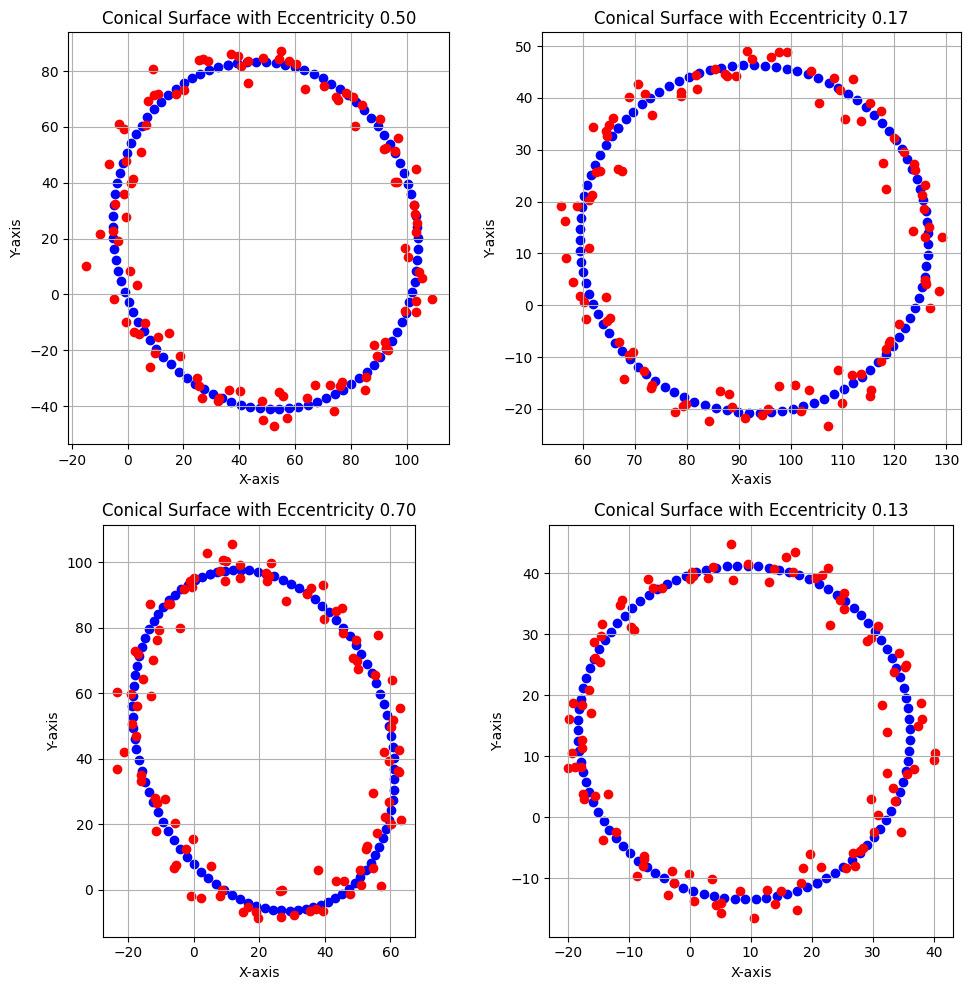

In [208]:
num_plots = 4
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Randomly choose 4 indices to plot
indices_to_plot = np.random.choice(samples, 4, replace=False)

# Plotting each subplot
for i, idx in enumerate(indices_to_plot):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    axs[row, col].scatter(x_values[idx], y_values[idx],color='blue')
    axs[row, col].scatter(x_noise[idx], y_noise[idx],color='red')

    axs[row, col].set_aspect('equal', adjustable='box')
    axs[row, col].set_title(f'Conical Surface with Eccentricity {e_values[idx]:.2f}')
    axs[row, col].set_xlabel('X-axis')
    axs[row, col].set_ylabel('Y-axis')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

In [209]:
#rede neural
#import tensorflow as tf
#from tensorflow import keras
from keras import models,layers,initializers

In [210]:
#input_data = [(x_noise[i], y_noise[i]) for i in range(len(x_noise))]
#input_data_flat = input_data.reshape((input_data.shape[0], -1))
input_data = np.concatenate([x_noise,y_noise],1)
output_data = np.column_stack([e_values])#,a_values])
print(input_data.shape)
print(e_values.shape)
print(output_data.shape)
print(len(input_data[0]))



(50000, 200)
(50000,)
(50000, 1)
200


In [211]:
def prepare_data(x,y):
    return np.concatenate([x_noise,y_noise],1)

In [212]:
# Criar o modelo sequencial
model = models.Sequential(name="my_neural")
model.add(layers.Input(shape=(2 * num_points,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2000, activation="relu", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))  # Adicionando Dropout
model.add(layers.Dense(1000, activation="tanh", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))  # Adicionando Dropout
model.add(layers.Dense(2000, activation="relu", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))  # Adicionando Dropout
model.add(layers.Dense(1, activation="linear"))  # Saída com duas unidades, uma para 'a' e outra para 'e'

model.compile(optimizer="adam",loss="mse",metrics=["mean_squared_error"])

model.summary()


Model: "my_neural"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_28          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2000)           │       402,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2000)           │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │         2,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,427,801 (16.89 MB)

 Trainable params: 4,417,401 (16.85 MB)

 Non-trainable params: 10,400 (40.62 KB)

In [213]:
#separando os dados
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(input_data,output_data,random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



In [214]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train,y_train,epochs=100,batch_size=100,validation_data=(x_test,y_test),callbacks=[early_stopping])

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - loss: 2.9775 - mean_squared_error: 2.9775 - val_loss: 0.1067 - val_mean_squared_error: 0.1067
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - loss: 0.1639 - mean_squared_error: 0.1639 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - loss: 0.0611 - mean_squared_error: 0.0611 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - loss: 0.0332 - mean_squared_error: 0.

In [215]:
# Accessing the training loss history
training_loss = history.history['loss']

# Accessing the validation loss history
validation_loss = history.history['val_loss']

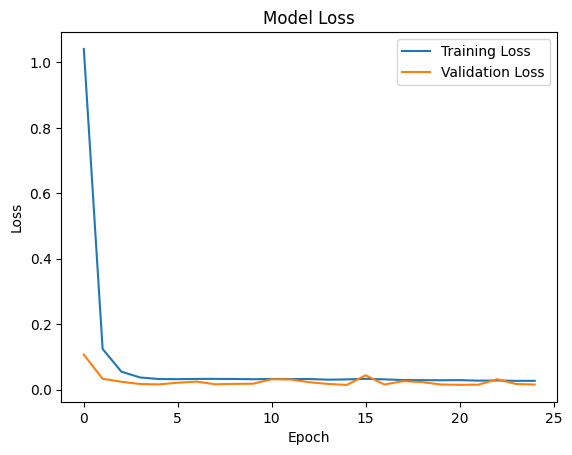

In [216]:
# Plot training & validation loss values
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [221]:
e=0.25
a=100

x_teste,y_teste = generate_elipses(e,a,100)
teste=np.concatenate([x_teste,y_teste])
# Reshape teste to match the expected input shape of your model
teste = np.expand_dims(teste, axis=0)  # Shape will be (1, 200)
teste = scaler.transform(teste)
pred=model.predict(teste)

print(pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.28020656]]


In [223]:
predict1=model.predict(x_test)

predict2=model.predict(x_train)



391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step


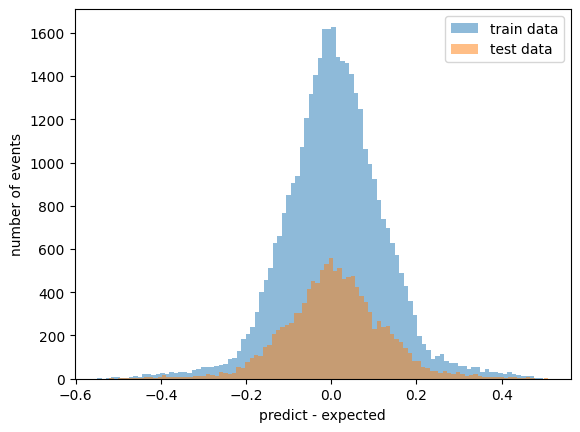

In [225]:

plt.hist(predict2-y_train,bins=100,label="train data",alpha=0.5)

plt.hist(predict1-y_test,bins=100,label="test data",alpha=0.5)
plt.xlabel("predict - expected")
plt.ylabel("number of events")
plt.legend()
plt.show()

In [241]:
#vamos fazer um heat map entre a e e

e_hm=np.linspace(0,1,100)
a_hm=np.linspace(0,100,100)

e_predict=np.zeros((len(e_hm),len(a_hm)))

for i,e_aux in enumerate(e_hm):
    for j,a_aux in enumerate(a_hm):

        x_aux,y_aux=generate_elipses(e_aux,a_aux,100)
        teste=np.concatenate([x_teste,y_teste])
        # Reshape teste to match the expected input shape of your model
        teste = np.expand_dims(teste, axis=0)  # Shape will be (1, 200)
        teste = scaler.transform(teste)
        pred=model.predict(teste)
        
        e_predict[i][j]=np.abs(pred[0][0]-e_aux)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

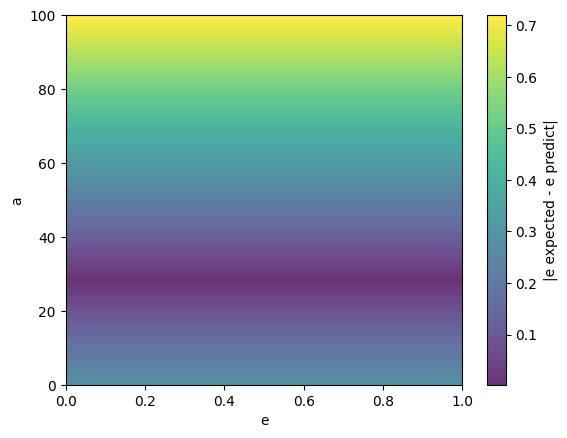

In [261]:
# Criar o heatmap
plt.imshow(e_predict, extent=[e_hm.min(), e_hm.max(), a_hm.min(), a_hm.max()], origin='lower', cmap='viridis', alpha=0.8, aspect='auto')

# Adicionar a barra de cores
cbar = plt.colorbar()
cbar.set_label('|e expected - e predict|')  # Rótulo da barra de cores
plt.xlabel("e")
plt.ylabel("a")
plt.show()


array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
       0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
       0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
       0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
       0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
       0.07007007, 0.07107107, 0.07207207, 0.07307307, 0.07407